In [1]:
import gtfstk as gt # https://mrcagney.github.io/gtfstk_docs/, https://github.com/mrcagney/gtfstk/blob/master/ipynb/examples.ipynb
import pandas as pd # https://pandas.pydata.org/pandas-docs/stable/index.html
import geopandas as gpd # http://geopandas.org/
import numpy as np # https://www.numpy.org/
import folium # https://python-visualization.github.io/folium/
from shapely.geometry import Point, Polygon # https://shapely.readthedocs.io/en/latest/
import matplotlib.pyplot as plt # https://matplotlib.org/
import osmnx as ox # https://osmnx.readthedocs.io/en/stable/index.html
from IPython.display import clear_output
# Enables plotting in Jupyter notebook
%matplotlib inline

In [2]:
# Put GTFS file path here:
gtfs= r"N:\Planning - New File Structure\GIS\Data\OFFICIAL CURRENT\GTFS\VRT_Transit1.zip"
# Configurables
num_bins= 5 # How many categories the service levels should be sliced into
service_dates=['20190705','20190706','20190707'] # weekday, Saturday, Sunday in YYYYMMDD format.
buffer_distance=.5 # miles
grid_size=.125 # miles
crs={'init':'epsg:4326'} # WGS84 projection
outfile=r"N:\Planning - New File Structure\GIS\Data\Accessibility\{}.shp" # Location to store outputs
save_files=False

In [3]:
# Convert distances from miles to Decimal Degrees (WGS84 Units)
# one_deg_lat=69.05397727272727 # miles
# one_deg_lon=48.99318181818182 # miles
# conversion=(np.mean([one_deg_lat,one_deg_lon]))

In [9]:
# Read in files, make sure projections match, provide location for data output, and build grid points

employers=pd.read_excel(r"\\VRIDE-FS2\Project\Projects\Fare\Employer Programs\GFI_FareTypeDataByRouteFY2018.xlsx",sheet_name='Sheet2') # Employer and ridership information
feed=gt.read_gtfs(gtfs,dist_units='mi') # Read in GTFS feed to gtfstk
# xmin,ymin,xmax,ymax=gt.miscellany.compute_bounds(feed)
# xmin=xmin*1.001
# ymin=ymin*0.999
# xmax=xmax*0.999
# ymax=ymax*1.001
# rows=int(np.ceil((ymax-ymin)/grid_size))
# cols=int(np.ceil((xmax-xmin)/grid_size))
# grid_points=[]
# XleftOrigin = xmin
# XrightOrigin = xmin + grid_size
# YtopOrigin = ymax
# YbottomOrigin = ymax- grid_size
# for i in range(cols):
#     Ytop=YtopOrigin
#     Ybottom=YbottomOrigin
#     for j in range(rows):
#         grid_points.append(Point([XleftOrigin,Ytop]))
#         Ytop=Ytop-grid_size
#         Ybottom=Ybottom-grid_size
#     XleftOrigin=XleftOrigin + grid_size
#     XrightOrigin=XrightOrigin + grid_size
# grid=gpd.GeoDataFrame({'geometry':grid_points},crs=crs)
# grid['OBJECTID']=grid.index

In [5]:
def pointScorer(buffer_distance,grid_size,save_file=False,buffer_type='euclidean'):
    output=gpd.GeoDataFrame(crs=crs)
    output2=gpd.GeoDataFrame(crs=crs)
    one_deg_lat=69.05397727272727 # miles
    one_deg_lon=48.99318181818182 # miles
    conversion_deg=(np.mean([one_deg_lat,one_deg_lon]))
    buffer_distance_deg=buffer_distance/conversion_deg
    buffer_distance_met=buffer_distance*1609.34
    Dbin=(2,85)
    Cbin=(85,400)
    Bbin=(400,1000)
    Abin=(1000,7927)
    bins=pd.IntervalIndex.from_tuples([Dbin,Cbin,Bbin,Abin])
    labels=['A','B','C','D']
    grid_size_deg=grid_size/conversion_deg
    stops=feed.stop_times
    stops=stops.merge(gt.stops.geometrize_stops(feed.stops))
    stops=stops.merge(gt.stops.compute_stop_stats(feed,dates=service_dates),sort=False)
    stops=stops.merge(feed.trips)
    stops=stops.merge(feed.routes)
    stops=stops.groupby(['stop_id','shape_id'],as_index=False).first()
    stops=gpd.GeoDataFrame(stops,geometry='geometry',crs=crs)
    xmin,ymin,xmax,ymax=gt.miscellany.compute_bounds(feed)
    xmin=xmin*1.001
    ymin=ymin*0.999
    xmax=xmax*0.999
    ymax=ymax*1.001
    rows=int(np.ceil((ymax-ymin)/grid_size_deg))
    cols=int(np.ceil((xmax-xmin)/grid_size_deg))
    grid_points=[]
    XleftOrigin = xmin
    XrightOrigin = xmin + grid_size_deg
    YtopOrigin = ymax
    YbottomOrigin = ymax- grid_size_deg
    for i in range(cols):
        Ytop=YtopOrigin
        Ybottom=YbottomOrigin
        for j in range(rows):
            grid_points.append(Point([XleftOrigin,Ytop]))
            Ytop=Ytop-grid_size_deg
            Ybottom=Ybottom-grid_size_deg
        XleftOrigin=XleftOrigin + grid_size_deg
        XrightOrigin=XrightOrigin + grid_size_deg
    grid=gpd.GeoDataFrame({'geometry':grid_points},crs=crs)
    grid['OBJECTID']=grid.index
    grid['Coords']=list(zip(grid.geometry.y,grid.geometry.x))
    grid_buff=gpd.GeoDataFrame(crs=crs)
    for index,row in grid.iterrows():
        clear_output(wait=True)
        if buffer_type=='euclidean':
            df=gpd.GeoDataFrame(grid.iloc[[index]],geometry='geometry',crs=crs)
            df['geometry']=df.geometry.buffer(buffer_distance_deg)
        if buffer_type=='walkshed':
            try:
                df=ox.graph_to_gdfs(ox.graph_from_point(row['Coords'], distance=800,distance_type='network',network_type='walk'),nodes=False,edges=True)
            except Exception:
                continue
        df['OBJECTID']=index
        df=df.dissolve(by='OBJECTID')
        df['geometry']=df['geometry'].convex_hull
        grid_buff=grid_buff.append(df,sort=True)
        print('{}% Walked ({} out of {})'.format(str(round((len(grid_buff)/len(grid)*100),1)),len(grid_buff),len(grid)))
    for i in range(len(grid_buff)):
        clear_output(wait=True)
        df=grid_buff.iloc[[i]]
        df=gpd.sjoin(df,stops,how='inner')
        df['OBJECTID']=df.index
        df=df[['OBJECTID','stop_id','stop_name','shape_id','route_id','route_short_name','num_routes','num_trips']]
        df=df.groupby(['OBJECTID','shape_id'],as_index=False).min()
        output=output.append(df,sort=True)
        print('{}% Scored ({} out of {})'.format(str(round((len(output)/len(grid_buff)*100),1)),len(output),len(grid_buff)))
    output=output.groupby('OBJECTID',as_index=False).sum()
    output=output.merge(grid)
    output=gpd.GeoDataFrame(output,geometry='geometry',crs=crs)
    output=output[['OBJECTID','num_trips','geometry']]
    output['Class']=pd.cut(output['num_trips'],bins=bins)
    output.replace(pd.Interval(2, 85, closed='right'),'D',inplace=True)
    output.replace(pd.Interval(85, 400, closed='right'),'C',inplace=True)
    output.replace(pd.Interval(400, 1000, closed='right'),'B',inplace=True)
    output.replace(pd.Interval(1000, 7927, closed='right'),'A',inplace=True)
    for index, row in output.iterrows():
        clear_output(wait=True)
        df=gpd.GeoDataFrame(row,crs=crs).T
        df['geometry']=df.geometry.buffer(grid_size_deg)
        output2=output2.append(df)
        print('{}% Dissolved ({} out of {})'.format(str(round(((index+1)/len(output2)*100),1)),index+1,len(output2)))
    output2['num_trips']=output2['num_trips'].astype(float)
    output2=output2.dissolve(by='Class',aggfunc='mean').reset_index()
    output2.sort_values('Class',ascending=False,inplace=True)
    output2['geometry']=output2['geometry'].difference(output2.shift(-1))
    if save_file:
        output.to_file(outfile.format('points_analysis'))
    return output2

In [6]:
output=pointScorer(buffer_distance,grid_size,save_file=False)

100.0% Dissolved (5388 out of 5388)


In [10]:
employers['Coordinates']=list(zip(employers.Longitude,employers.Latitude))
employers['Coordinates']=employers['Coordinates'].apply(Point)
employers=employers.dropna(axis=0,subset=['Latitude','Longitude'])
employers=gpd.GeoDataFrame(employers,geometry='Coordinates',crs=crs)

In [ ]:
employers=gpd.sjoin(employers,output,how='left')
# employers.drop(['index_right','index'],inplace=True,axis=1)

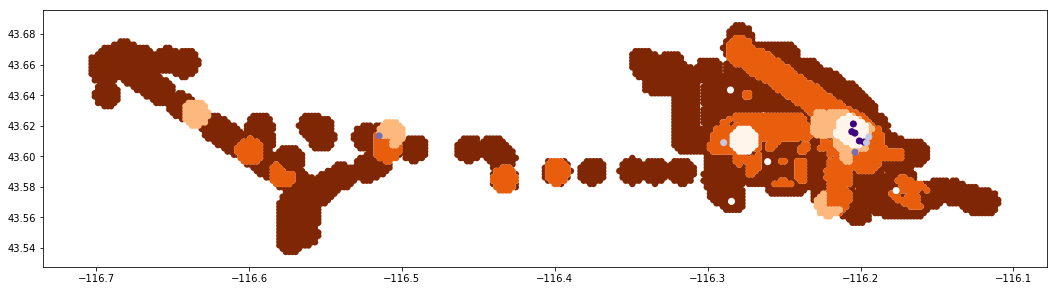

In [20]:
base=output.plot(figsize=(18,16),column='Class',cmap='Oranges')
employers.plot(ax=base,column='Class',cmap='Purples_r')

In [15]:
# employers['Boardings per employee']=employers['Annual pass boardings Total']/employers['Employees']
# employers.sort_values('Boardings per employee',ascending=False,inplace=True)
# employers.drop_duplicates(subset={'Employer','Campus'},inplace=True)
employers

,Employer,Campus,Employees,Students,Annual pass boardings Staff/Employees,Boardings/Employee,Annual Pass Boardings Students,Boardings/Student,Latitude,Longitude,Coordinates,index_right,Class,num_trips
0,Boise State,1,3304.0,22113.0,10258.0,3.104722,98981.0,4.476145,43.602699,-116.203649,POINT (-116.2036491 43.6026991),1,B,662.533040
1,City of Boise,NaN,1700.0,NaN,18600.0,10.941176,NaN,NaN,43.615182,-116.203687,POINT (-116.2036867 43.6151819),0,A,2725.237288
2,Ada County,"Emerald, Benjamin Areas",794.0,NaN,606.0,0.763224,NaN,NaN,43.608970,-116.289523,POINT (-116.2895227 43.6089703),2,C,144.706306
3,Ada County,Front Street Complex,774.0,NaN,2897.0,3.742894,NaN,NaN,43.609360,-116.197702,POINT (-116.1977021 43.6093603),2,C,144.706306
3,Ada County,Front Street Complex,774.0,NaN,2897.0,3.742894,NaN,NaN,43.609360,-116.197702,POINT (-116.1977021 43.6093603),0,A,2725.237288
4,St. Luke's,Downtown Boise,7000.0,NaN,12736.0,1.819429,NaN,NaN,43.612756,-116.194560,POINT (-116.1945603 43.6127562),2,C,144.706306
5,Boise School District,Boise High School,675.0,1520.0,258.0,0.382222,36784.0,24.200000,43.621182,-116.204718,POINT (-116.2047179 43.621182),0,A,2725.237288
6,Boise School District,Borah High School,676.0,1538.0,437.0,0.646450,13331.0,8.667750,43.596504,-116.260757,POINT (-116.2607572 43.5965043),3,D,34.293310
7,Boise School District,Timberline High School,505.0,1400.0,166.0,0.328713,8814.0,6.295714,43.577608,-116.176770,POINT (-116.1767698 43.5776084),3,D,34.293310
8,Boise School District,Frank Church High School,97.0,467.0,33.0,0.340206,10221.0,21.886510,43.570542,-116.284441,POINT (-116.2844413 43.570542),3,D,34.293310


In [21]:
save_files=True
if save_files:
    employers.to_file(outfile.format('employers'))

c:\users\bparker\appdata\local\conda\conda\envs\py3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
